In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import special, stats
import math
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('max_columns', None)

# Change this as needed to load the datasets
current_directory = "./"

# COVID Data: An Exploration of Variants
____

Lindsey Uribe

*December 8, 2021*

Despite our tiring of COVID-19, and a desperate desire to return to "normal", it seems that COVID is not tiring of us. There is now a new COVID variant that has been ramping up in Botswana and South Africa since early August of 2021. This new variant, *Omicron* (also known as *B.1.1.529*), has been found to have enough significant mutations as to cause the UK and United States to shut down flights incoming from South Africa$^{[\dagger]}$$^{[\star]}$. The predominant fear is that this variant has so many mutations that it will render all of our current vaccines ineffective, and a new flush of covid will spread throughout the globe once more, unimpeded by our most touted of solutions. For the majority of Americans, we've found ourselves at the sharp end of that solution, but does a vaccinated population actually have fewer covid variants? And how does the number of variants increase or decrease over time? 

According to the CDC, *“Vaccines remain the best public health measure to protect people from COVID-19, slow transmission, and reduce the likelihood of new variants emerging.”* $^{[\diamond]}$
Clearly, the CDC is arguing that vaccines do indeed have an effect on a reduction of opportunities for viral mutations, simply by a reduction in transmissibility of the virus. I can wrap my brain around that argument: the fewer people infected, the fewer hosts available in which a virus can undergo mutations, thus a reduced number of variants theoretically present in the population. But do the data support that argument? 

The two major questions that I want to explore: 
 - **Does an increasingly vaccinated population have any relationship to a reduction in the number of COVID variants present in a country?** This is a roundabout way of trying to take a crack at the question lots of people want answered: Do vaccines even matter? Would this variant have happened anyway, vaccines or no vaccines? Some might argue that vaccines have no effect on variants, but given the stance of the CDC, the official argument is that there is a reduction in the likelihood of novel variants creditable to vaccines.

 - **Does the number of variants detected in a population increase according to an exponential distribution?** In other words, is there any way I could try to predict the number of variants that might be present globally, just given some kind of timeframe? Without considering anything else, in just the simplest of terms, could I possibly figure out whether, in two years time, we will have say, 24 variants? 

<br>
_______

One very important note: The dataset `variants` is **not** the result of random sampling. The variants included here are those that have been detected via genomic sequencing across the globe and deemed to be "variants of concern" or "variants of interest". Considering that the accumulation of this dataset is the collective feat of the world, and it's just about as thorough as we humans can be on a global scale at this point in time, I have little choice but to treat this data as anything other than a census-like (albeit flawed) collection of genomic sequencing. Thus while performing my tests below, it's important to note that I am considering the *population* here to be the detectable traces of these variants themselves. In other words, the dataset *is* my population and I will be sampling randomly from that population. 


<br><br>
____

## Initial Data Exploration & Preparation

### Data preparation

In [2]:

##############################
# Global Variant Detection Data
##############################
variants = pd.read_csv(current_directory + 'covid-variants.csv')
variants['year'] = variants['date'].str[0:4]
variants['month'] = variants['date'].str[5:7]
# Figuring out how to merge the variant and postvax data for my viable countries
# According to the logs for the `variants` dataset, we should be sure to exclude the 'non_who' variant category in order to 
# avoid double-counting. Filtering those out now.
variants_no_nonwho = variants.loc[variants['variant'] != 'non_who']
assert len(variants_no_nonwho) != len(variants)




##############################
# Global Vaccination Data
##############################
vaccinations = pd.read_csv(current_directory + 'vaccinations.csv').fillna(0)




##############################
# Population Parameters Data
##############################
# These populations are given in millions, which I don't like. So I'm just converting to the real-valued numbers here for clarity. 
population_params = pd.read_csv(current_directory + 'world_population2020.csv').filter(['name', 'pop2021', 'pop2020', 'pop2019'])
# These data for populations are in millions. Converting them now just for clarity
for column in population_params.columns: 
    if 'pop20' in column: 
        population_params[column] = population_params[column] * 1_000
        

To try and gain some insights into viral variants present in our global population, I'll explore data from these three datasets: 

This data is a composite collection pulled from three different sources:
 - `vaccinations`: This dataset contains information as to the number of vaccinations per country for dates between 2019 and 2021. I will be extracting vaccination data for the month of September in order to determine the potential linear relationship between vaccination rates and variants. The full dataset is updated every six hours or so here: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv
 - `variants` : This data set contains the number of COVID variants present in each country. It can be found at this github page: https://github.com/owid/covid-19-data/blob/master/public/data/variants/covid-variants.csv. The original data source is CoVariant (see resources)$^{[\ddagger]}$. I'll be using this while working through the linear regression for my second hypothesis test.
 - `world_population_by_country` : a simple dataset for estimated populations for every country in the world, essential for engineering the additional feature, `proportion_vaccinated`, in the data later on. These data are available here: https://worldpopulationreview.com/ 

Here is what each of the three datasets look like after a little cleaning and organizing: 

In [3]:
display(population_params.sample(5), vaccinations.sample(5), variants_no_nonwho.sample(5))

,name,pop2021,pop2020,pop2019
111,El Salvador,6518499.00,6486205.00,6453553.00
132,Eritrea,3601467.00,3546421.00,3497117.00
71,Chad,16914985.00,16425864.00,15946876.00
105,Paraguay,7219638.00,7132538.00,7044636.00
151,Bahrain,1748296.00,1701575.00,1641172.00


,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
46023,Philippines,PHL,2021-08-01,0.00,0.00,0.00,0.00,0.00,488786.00,0.00,0.00,0.00,0.00,4402.00,87103.00,0.08
23741,Guernsey,GGY,2021-05-29,0.00,0.00,0.00,0.00,0.00,769.00,0.00,0.00,0.00,0.00,12132.00,0.00,0.00
12443,Congo,COG,2021-05-09,0.00,0.00,0.00,0.00,0.00,852.00,0.00,0.00,0.00,0.00,151.00,852.00,0.01
15620,Djibouti,DJI,2021-11-09,0.00,0.00,0.00,0.00,0.00,317.00,0.00,0.00,0.00,0.00,316.00,317.00,0.03
2541,Argentina,ARG,2021-07-27,30230385.00,24096445.00,6133940.00,0.00,350138.00,343594.00,66.29,52.84,13.45,0.00,7534.00,250625.00,0.55


,location,date,variant,num_sequences,perc_sequences,num_sequences_total,year,month
53671,Zambia,2020-08-03,B.1.258,0,0.00,177,2020,08
46430,Spain,2021-09-06,Gamma,8,0.25,3215,2021,09
38052,Portugal,2021-06-28,Epsilon,0,0.00,1170,2021,06
1447,Aruba,2021-07-26,B.1.258,0,0.00,97,2021,07
9967,Colombia,2021-05-03,B.1.258,0,0.00,397,2021,05


In [4]:
vaccinations_start_to_current = (vaccinations.loc[vaccinations['people_vaccinated'] != 0]
                                 .filter(['location', 'date', 'people_vaccinated']))
vaccinations_start_to_current['year'] = vaccinations_start_to_current['date'].str[0:4]
vaccinations_start_to_current['month'] = vaccinations_start_to_current['date'].str[5:7]

# I want to remove all the aggregated values by continent and just focus in on country-specific data
valid_countries = population_params['name']

vaccinations_by_country = vaccinations_start_to_current.loc[vaccinations_start_to_current['location'].isin(valid_countries)]
vaccinations_by_country

,location,date,people_vaccinated,year,month
6,Afghanistan,2021-02-28,8200.00,2021,02
22,Afghanistan,2021-03-16,54000.00,2021,03
44,Afghanistan,2021-04-07,120000.00,2021,04
59,Afghanistan,2021-04-22,240000.00,2021,04
78,Afghanistan,2021-05-11,448878.00,2021,05
...,...,...,...,...,...
64244,Zimbabwe,2021-11-22,3681490.00,2021,11
64245,Zimbabwe,2021-11-23,3697233.00,2021,11
64246,Zimbabwe,2021-11-24,3719630.00,2021,11
64247,Zimbabwe,2021-11-25,3738317.00,2021,11


In [5]:
# defining some global seasons variables for use in grouping later
winter = ['12', '01', '02']
spring = ['03', '04', '05']
summer = ['06', '07', '08']
fall = ['09', '10', '11']


# Selecting the 2020 vaccinations data
vaccinations_2020 = vaccinations_by_country.loc[vaccinations_by_country['year'] == '2020']
vaccinations_2020

# Selecting the 2021 vaccinations data
vaccinations_2021 = vaccinations_by_country.loc[vaccinations_by_country['year'] == '2021']
vaccinations_2021

# Making sure I didn't somehow miss a year
assert len(vaccinations_2021) + len(vaccinations_2020) == len(vaccinations_by_country)

# Merging the population parameters for the right years and appending the tables back together 
# This way, the vaccination data can be calculated as a percentage of the total population for the 
# corresponding year in which the data was collected.
vaxx_w_pop2021 = pd.merge(vaccinations_2021, population_params[['name', 'pop2021']], how='left', left_on='location', right_on='name')
vaxx_w_pop2020 = pd.merge(vaccinations_2020, population_params[['name', 'pop2020']], how='left', left_on='location', right_on='name')
vaxx_w_pop2021.rename(columns={'pop2021': 'population'}, inplace=True)
vaxx_w_pop2020.rename(columns={'pop2020': 'population'}, inplace=True)
vaccinations_and_populations = vaxx_w_pop2021.append(vaxx_w_pop2020).filter(['location', 'date', 'people_vaccinated', 'year', 'month', 'population'])
vaccinations_and_populations['pct_pop_vaccinated'] = vaccinations_and_populations['people_vaccinated'] / vaccinations_and_populations['population']
vaccinations_and_populations.loc[vaccinations_and_populations['month'].isin(winter)==True, 'seasons'] = 'Winter'
vaccinations_and_populations.loc[vaccinations_and_populations['month'].isin(spring)==True, 'seasons'] = 'Spring'
vaccinations_and_populations.loc[vaccinations_and_populations['month'].isin(summer)==True, 'seasons'] = 'Summer'
vaccinations_and_populations.loc[vaccinations_and_populations['month'].isin(fall)==True, 'seasons'] = 'Fall'

# # Next I want to see how many countries I could legitimately expect to be seeing *some* kind of an effect
# # from higher levels of vaccinations. Here are the countries that all have at least 50% of their population vaccinated.
max_vax = vaccinations_and_populations.groupby(['location'], as_index=False).agg({'pct_pop_vaccinated': max})
majority_vaccinated =  max_vax.loc[max_vax['pct_pop_vaccinated'] > .5]

# Getting the names of the countries I can use for my tests
countries_w_majority_vaxxed = majority_vaccinated['location'].to_numpy() 
countries_w_majority_vaxxed


# Next, although it is interesting to see the different names and labels given to each variant, I don't need that data.
# I need to know how many variants are present in a given country.
pd.set_option('display.max_colwidth', None)
variants_cleaned = variants_no_nonwho.sort_values('variant').loc[variants_no_nonwho['perc_sequences'] != 0].groupby(['location', 'date'], as_index=False).agg({'variant': 'size'})
variants_cleaned.rename(columns={'variant': 'variants'}, inplace=True)
variants_cleaned['year'] = variants_cleaned['date'].str[0:4]
variants_cleaned['month'] = variants_cleaned['date'].str[5:7]

variants_cleaned.loc[variants_cleaned['month'].isin(winter)==True, 'seasons'] = 'Winter'
variants_cleaned.loc[variants_cleaned['month'].isin(spring)==True, 'seasons'] = 'Spring'
variants_cleaned.loc[variants_cleaned['month'].isin(summer)==True, 'seasons'] = 'Summer'
variants_cleaned.loc[variants_cleaned['month'].isin(fall)==True, 'seasons'] = 'Fall'

# Getting the names of those countries that have data on which variants were present, AND had a majority of their population vaccinated
# countries_to_sample = variants_cleaned.loc[variants_cleaned['location'].isin(countries_w_majority_vaxxed)]['location'].unique()


# Here's what variants_cleaned looks like
variants_cleaned.sort_values(['year', 'month', 'date'])

,location,date,variants,year,month,seasons
13,Argentina,2020-05-11,1,2020,05,Spring
67,Australia,2020-05-11,1,2020,05,Spring
108,Austria,2020-05-11,1,2020,05,Spring
156,Bangladesh,2020-05-11,1,2020,05,Spring
185,Belgium,2020-05-11,1,2020,05,Spring
...,...,...,...,...,...,...
1025,Italy,2021-11-26,1,2021,11,Fall
1743,Singapore,2021-11-26,1,2021,11,Fall
2050,Switzerland,2021-11-26,1,2021,11,Fall
2178,United Kingdom,2021-11-26,1,2021,11,Fall


# Exploration

## What are the predominant clusters in the data? 


______
**Principal Component Analysis**

In [6]:
# Any country that had any percentage of any variant greater than zero receives a boolean 1 under that variant to indicate "present"
variants_present_by_country = variants_no_nonwho.pivot_table(index=['location', 'date'], columns='variant', values='perc_sequences', aggfunc=lambda x: x > 0).astype(str)
variants_present_by_country.reset_index(inplace=True)

for column in variants_present_by_country.columns: 
    if column == 'location' or column == 'date': 
        continue
    variants_present_by_country[column] = variants_present_by_country[column].str.replace('False', '0')
    variants_present_by_country[column] = variants_present_by_country[column].str.replace('True', '1')
    variants_present_by_country[column] = variants_present_by_country[column].astype(float)

variants_present_by_country.head(5)

variant,location,date,Alpha,B.1.1.277,B.1.1.302,B.1.1.519,B.1.160,B.1.177,B.1.221,B.1.258,B.1.367,B.1.620,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,S:677H.Robin1,S:677P.Pelican,others
0,Angola,2020-12-21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,Angola,2021-01-25,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,Angola,2021-02-08,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,Angola,2021-02-22,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,Angola,2021-03-08,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [7]:
seasonal_variants = variants_present_by_country.copy()
seasonal_variants['month'] = seasonal_variants['date'].str[5:7].astype(float)
seasonal_variants['year'] = seasonal_variants['date'].str[0:4].astype(float)
seasonal_variants['seasons'] = np.ones(len(seasonal_variants))

winter = ['12', '01', '02']
spring = ['03', '04', '05']
summer = ['06', '07', '08']
fall = ['09', '10', '11']


seasonal_variants.loc[seasonal_variants['month'].isin(winter)==True, 'seasons'] = 1
seasonal_variants.loc[seasonal_variants['month'].isin(spring)==True, 'seasons'] = 2
seasonal_variants.loc[seasonal_variants['month'].isin(summer)==True, 'seasons'] = 3
seasonal_variants.loc[seasonal_variants['month'].isin(fall)==True, 'seasons'] = 4

seasonal_variants.head()

variant,location,date,Alpha,B.1.1.277,B.1.1.302,B.1.1.519,B.1.160,B.1.177,B.1.221,B.1.258,B.1.367,B.1.620,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,S:677H.Robin1,S:677P.Pelican,others,month,year,seasons
0,Angola,2020-12-21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,12.00,2020.00,1.00
1,Angola,2021-01-25,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,2021.00,1.00
2,Angola,2021-02-08,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2021.00,1.00
3,Angola,2021-02-22,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2021.00,1.00
4,Angola,2021-03-08,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,2021.00,2.00


In [8]:
# Preparing for matrix calculations again...
numeric_seasonal_variants = seasonal_variants.drop(columns=['location', 'date'], axis=1, inplace=False)
numeric_seasonal_variants.head(5)

variant,Alpha,B.1.1.277,B.1.1.302,B.1.1.519,B.1.160,B.1.177,B.1.221,B.1.258,B.1.367,B.1.620,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,S:677H.Robin1,S:677P.Pelican,others,month,year,seasons
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,12.00,2020.00,1.00
1,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,2021.00,1.00
2,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2021.00,1.00
3,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2021.00,1.00
4,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,2021.00,2.00


In [9]:
# centering the data by subtracting the mean from each column
centered_numeric_seasonal_variants = numeric_seasonal_variants - numeric_seasonal_variants.mean(axis=0)
centered_numeric_seasonal_variants

variant,Alpha,B.1.1.277,B.1.1.302,B.1.1.519,B.1.160,B.1.177,B.1.221,B.1.258,B.1.367,B.1.620,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,S:677H.Robin1,S:677P.Pelican,others,month,year,seasons
0,-0.55,-0.06,-0.02,-0.08,-0.23,-0.29,-0.17,-0.23,-0.04,-0.05,0.68,-0.51,-0.09,0.84,-0.26,-0.08,-0.08,-0.10,-0.11,-0.00,-0.02,-0.02,0.19,5.43,-0.72,-1.66
1,0.45,-0.06,-0.02,-0.08,0.77,0.71,-0.17,0.77,-0.04,-0.05,0.68,-0.51,-0.09,-0.16,-0.26,-0.08,-0.08,-0.10,-0.11,-0.00,-0.02,-0.02,0.19,-5.57,0.28,-1.66
2,0.45,-0.06,-0.02,-0.08,0.77,-0.29,-0.17,-0.23,-0.04,-0.05,0.68,-0.51,-0.09,-0.16,-0.26,-0.08,-0.08,-0.10,-0.11,-0.00,-0.02,-0.02,0.19,-4.57,0.28,-1.66
3,0.45,-0.06,-0.02,-0.08,0.77,0.71,-0.17,-0.23,-0.04,-0.05,0.68,-0.51,-0.09,-0.16,-0.26,-0.08,-0.08,-0.10,-0.11,-0.00,-0.02,-0.02,0.19,-4.57,0.28,-1.66
4,0.45,-0.06,-0.02,-0.08,-0.23,0.71,-0.17,-0.23,-0.04,-0.05,0.68,-0.51,-0.09,-0.16,-0.26,-0.08,-0.08,-0.10,-0.11,-0.00,-0.02,-0.02,0.19,-3.57,0.28,-0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,-0.55,-0.06,-0.02,-0.08,-0.23,-0.29,-0.17,-0.23,-0.04,-0.05,0.68,-0.51,-0.09,-0.16,-0.26,-0.08,-0.08,-0.10,-0.11,-0.00,-0.02,-0.02,0.19,-5.57,0.28,-1.66
2250,-0.55,-0.06,-0.02,-0.08,-0.23,-0.29,-0.17,-0.23,-0.04,-0.05,0.68,-0.51,-0.09,-0.16,-0.26,-0.08,-0.08,-0.10,-0.11,-0.00,-0.02,-0.02,0.19,-5.57,0.28,-1.66
2251,-0.55,-0.06,-0.02,-0.08,-0.23,-0.29,-0.17,-0.23,-0.04,-0.05,0.68,-0.51,-0.09,-0.16,-0.26,-0.08,-0.08,-0.10,-0.11,-0.00,-0.02,-0.02,-0.81,-4.57,0.28,-1.66
2252,-0.55,-0.06,-0.02,-0.08,-0.23,-0.29,-0.17,-0.23,-0.04,-0.05,-0.32,0.49,-0.09,-0.16,-0.26,-0.08,-0.08,-0.10,-0.11,-0.00,-0.02,-0.02,-0.81,0.43,0.28,0.34


In [10]:
# Next, computing the SVD and displaying the values in V-transpose
# Using full_matrices=False so that I can conveniently check my work
seasonal_U, seasonal_S, seasonal_Vt = np.linalg.svd(centered_numeric_seasonal_variants, full_matrices=False)

In [11]:
# Getting the principal components, only keeping the first two, since I want to consider 2-D only for ease of plotting
# and clustering
pcs_seasonal = seasonal_U * seasonal_S
pcs_seasonal[:, :2]

array([[-4.78145959, -1.91547388],
       [ 5.88988254, -0.82930088],
       [ 4.89171161, -0.30263638],
       ...,
       [ 4.76252226,  0.19457695],
       [-0.62676126,  0.7832738 ],
       [-0.62676126,  0.7832738 ]])

In [12]:
# Taking a look at the value for each principal component. A 2-D scatter plot may not be actually be suitable. Now this is getting a little
# more interesting...
np.round(seasonal_S)

array([156.,  41.,  34.,  29.,  23.,  19.,  17.,  15.,  14.,  13.,  12.,
        12.,  11.,  11.,  11.,  10.,   9.,   9.,   9.,   9.,   8.,   8.,
         7.,   6.,   5.,   1.])

In [13]:
# Computing how much information was lost by reducting to 2-D
seasonal_loss = (seasonal_S ** 2) / sum(seasonal_S ** 2)
print(f"About {sum(seasonal_loss[0:1]):.3%} of the variance is contained within the first principal component.")
print(f"About {sum(seasonal_loss[0:2]):.3%} of the variance is contained within the first two principal components")
print(f"About {sum(seasonal_loss[0:3]):.3%} of the variance is contained within the first three principal components")
print(f"About {sum(seasonal_loss[0:4]):.3%} of the variance is contained within the first four principal components")

About 78.072% of the variance is contained within the first principal component.
About 83.568% of the variance is contained within the first two principal components
About 87.335% of the variance is contained within the first three principal components
About 90.050% of the variance is contained within the first four principal components


Text(0.5, 0, 'Dimensions')

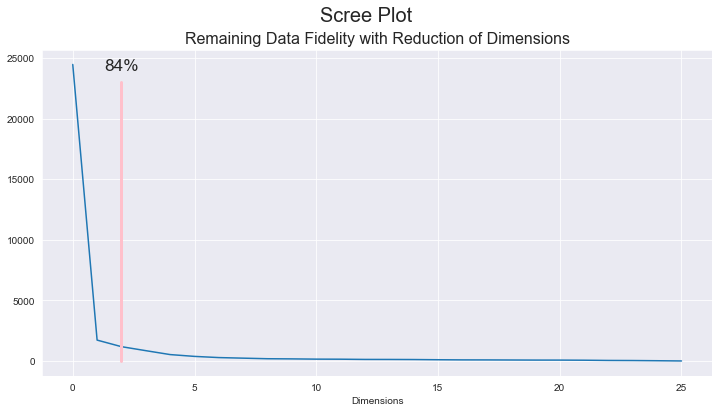

In [50]:
# Creating a scree plot to evaluate the PCA when seasons, months and years are taken into account
plt.figure(figsize=(12, 6))
plt.plot(seasonal_S ** 2)

plt.plot([2, 2], [0, 23000], color="pink", lw=3)
plt.text(2, 24000, "84%", horizontalalignment="center", fontsize="xx-large")

plt.suptitle("Scree Plot", fontsize=20)
plt.title("Remaining Data Fidelity with Reduction of Dimensions", fontsize=16)
plt.ylabel("")
plt.xlabel("Dimensions")

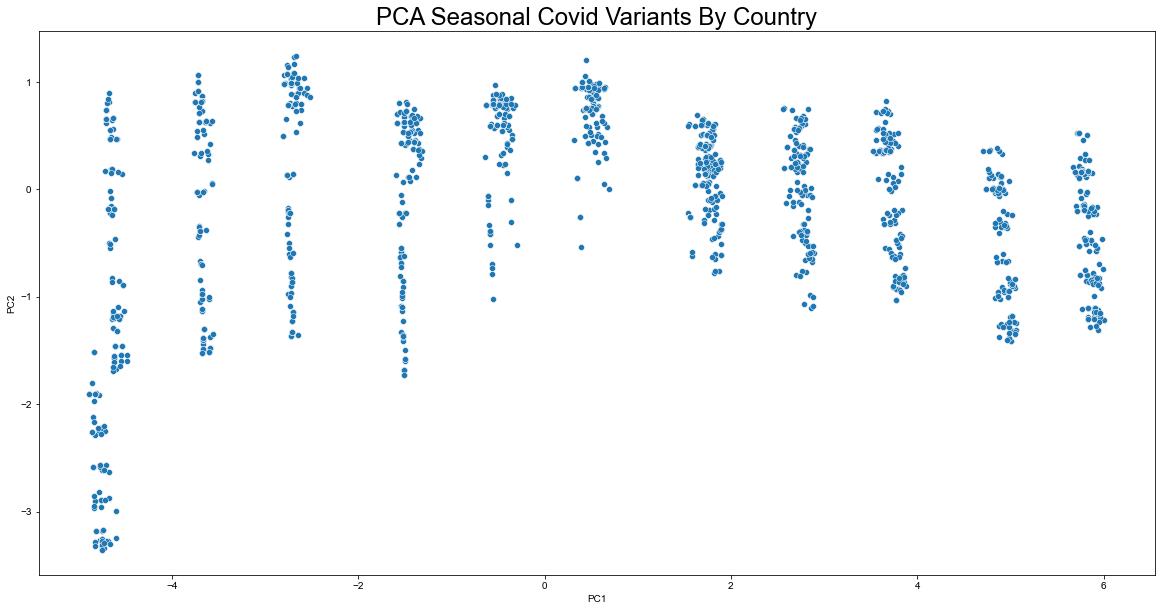

In [15]:
# Finally, taking a look at the data...

# Weird!
plt.figure(figsize=(20, 10))
sns.scatterplot(x=pcs_seasonal[:, 0], y=pcs_seasonal[:, 1])
sns.set_style("darkgrid")
plt.title("PCA Seasonal Covid Variants By Country", fontsize=24)
plt.xlabel("PC1")
plt.ylabel("PC2");

**So whatheck  is going on here?**

When I first ran the plot above, I thought I must have done something wrong. The clusters above are far too regular, far too columnar and just a little too weird. 

So I thought it might be interesting to see if I can pull some features of the original data back into the scatterplot, visually. 

The plots below are much more revealing. 

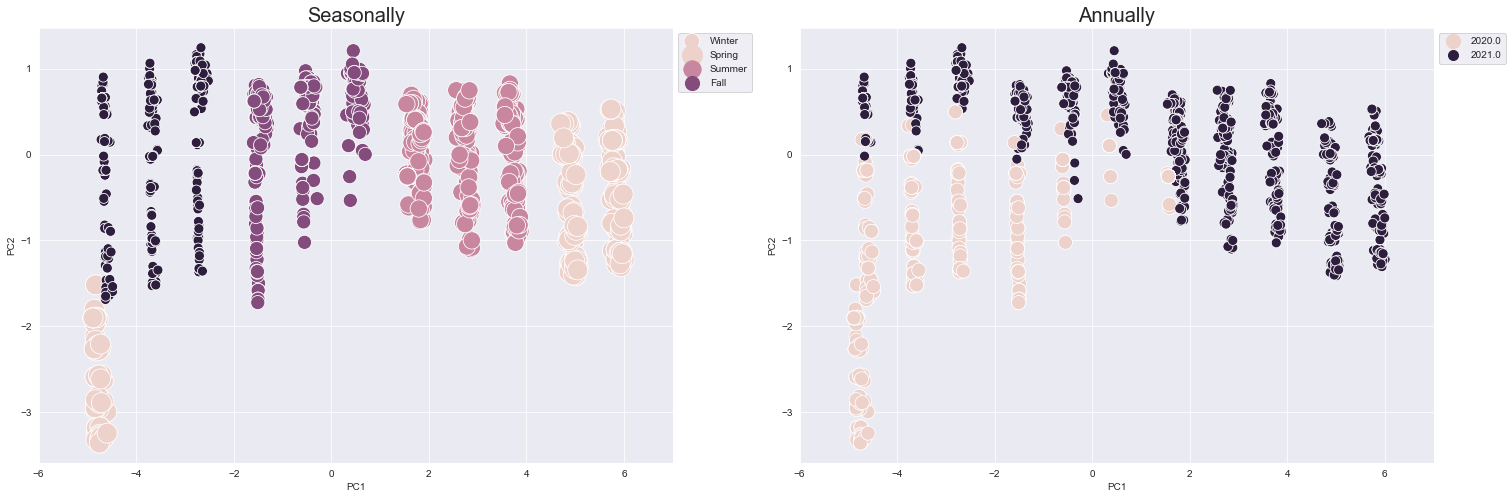

In [16]:
# Merging PCs with Original Dataset for Visual Cluster Evaluation
seasonal_variants['PC1'] = pcs_seasonal[:, 0]
seasonal_variants['PC2'] = pcs_seasonal[:, 1]


# Adding the defining features of the data back in for cluster visualization
plt.figure(figsize=(25, 8))
# sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white'})
sns.set_style("darkgrid")
plt.subplot(1, 2, 1)
plt.xlim(-6, 7)
plt.title("Seasonally", fontsize=20)
sns.scatterplot(data=seasonal_variants, x='PC1', y='PC2', hue='seasons', size='seasons', sizes=(400, 100));
plt.legend(bbox_to_anchor=(1,1), loc="upper left", labels=['Winter', 'Spring', 'Summer', 'Fall']);


# Not by year...
plt.subplot(1, 2, 2)
plt.xlim(-6, 7)
plt.title("Annually", fontsize=20)
sns.scatterplot(data=seasonal_variants, x='PC1', y='PC2', hue='year', size='year', sizes=(200, 100));
plt.legend(bbox_to_anchor=(1,1), loc="upper left");

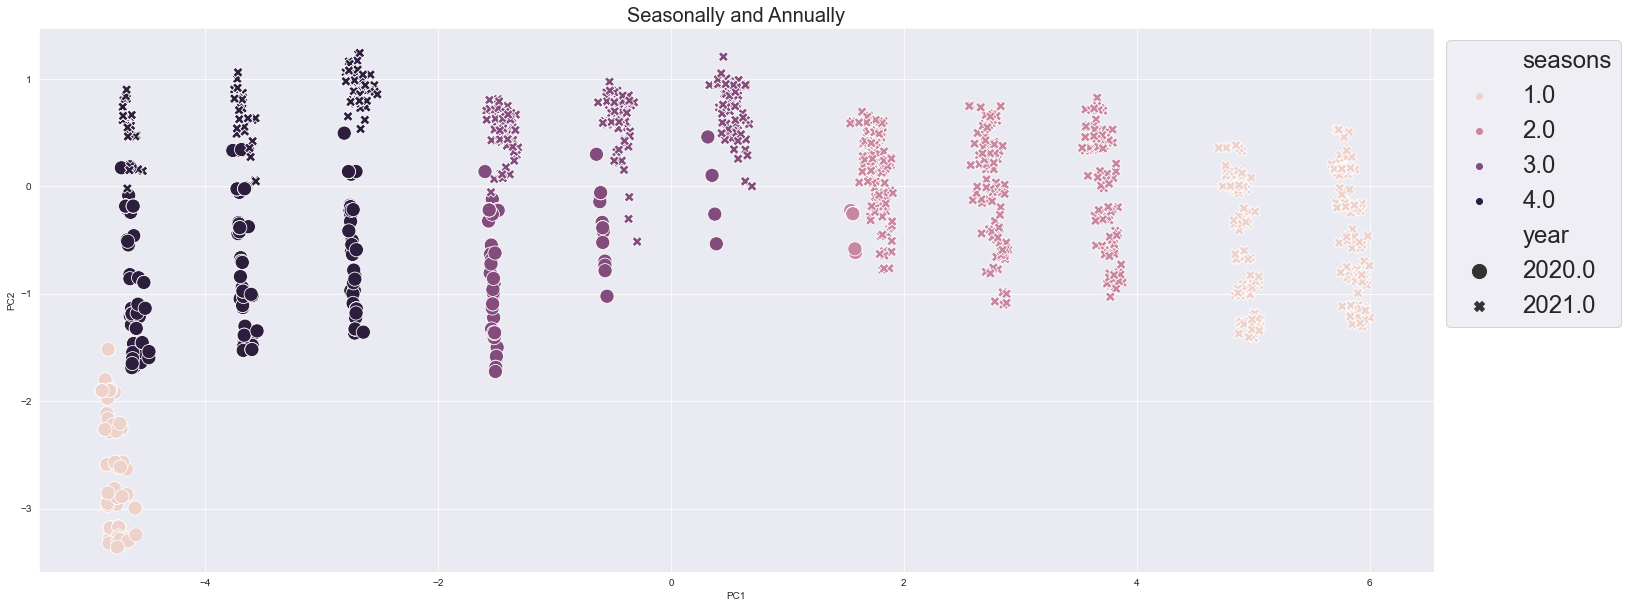

In [17]:
plt.figure(figsize=(25, 10))
plt.title("Seasonally and Annually", fontsize=20)
sns.set_style("darkgrid")
sns.scatterplot(data=seasonal_variants, x='PC1', y='PC2', hue='seasons', style='year', size='year', sizes=(200, 100));
plt.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=1, fontsize=24);

In [18]:
seasonal_variants

variant,location,date,Alpha,B.1.1.277,B.1.1.302,B.1.1.519,B.1.160,B.1.177,B.1.221,B.1.258,B.1.367,B.1.620,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,S:677H.Robin1,S:677P.Pelican,others,month,year,seasons,PC1,PC2
0,Angola,2020-12-21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,12.00,2020.00,1.00,-4.78,-1.92
1,Angola,2021-01-25,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,2021.00,1.00,5.89,-0.83
2,Angola,2021-02-08,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2021.00,1.00,4.89,-0.30
3,Angola,2021-02-22,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2021.00,1.00,4.91,-0.66
4,Angola,2021-03-08,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,2021.00,2.00,3.69,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,Zimbabwe,2021-01-11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,2021.00,1.00,5.76,0.16
2250,Zimbabwe,2021-01-25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,2021.00,1.00,5.76,0.16
2251,Zimbabwe,2021-02-08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2021.00,1.00,4.76,0.19
2252,Zimbabwe,2021-07-12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,2021.00,3.00,-0.63,0.78


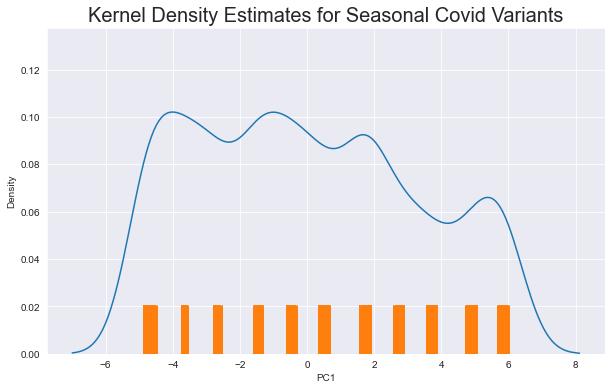

In [19]:
# Just out of curiousity, what if I were to try and reduce this down to 1-D? 
# This is the data in 1-dimension
seasonal_variants_1D = centered_numeric_seasonal_variants @ seasonal_Vt[:1].T
seasonal_variants_1D.loc[:, 0]
seasonal_variants_1D.rename(columns={0: "PC1"}, inplace=True)
seasonal_variants_1D

plt.figure(figsize=(10, 6))
sns.kdeplot(data=seasonal_variants_1D, x='PC1')
sns.rugplot(data=seasonal_variants_1D, x='PC1', height=.15)
sns.set_style("darkgrid")
plt.title("Kernel Density Estimates for Seasonal Covid Variants", fontsize=20);

### PCA: What did we learn? 

Essentially, this was nothing much more than a little side-track into how the seasons end up affecting fluctuations in our covid data. Unsurprisingly, each country experiences a slight increase or decrease in the number of variants as a function of the seasons. We might've predicted this, but a little PCA didn't hurt to confirm. 

### Further Exploration:

**A little exploration specifically regarding the potential relationships between an increasingly vaccinated population and the number of variants detected prior to running any tests.**
One of the items on any checklist that should be done prior to trying to find any linear relationship between two variables is running a scatter plot. Doing that here, plus a little more digging around in the data. 

In [20]:
# What are the starting dates of the first vaccinations for each country?
initial_vaccinations = vaccinations_by_country.loc[vaccinations_by_country['people_vaccinated'] > 0].groupby(['location'], as_index=False).first()
initial_vaccinations


# Interesting. I wonder who the first 30 people were in Algeria who got vaccinated on Jan 30, 2021 were...

,location,date,people_vaccinated,year,month
0,Afghanistan,2021-02-28,8200.00,2021,02
1,Albania,2021-01-12,128.00,2021,01
2,Algeria,2021-01-30,30.00,2021,01
3,Andorra,2021-01-25,576.00,2021,01
4,Angola,2021-03-08,6169.00,2021,03
...,...,...,...,...,...
199,Vietnam,2021-03-08,377.00,2021,03
200,Wallis and Futuna,2021-03-23,1286.00,2021,03
201,Yemen,2021-05-09,18555.00,2021,05
202,Zambia,2021-04-15,106.00,2021,04


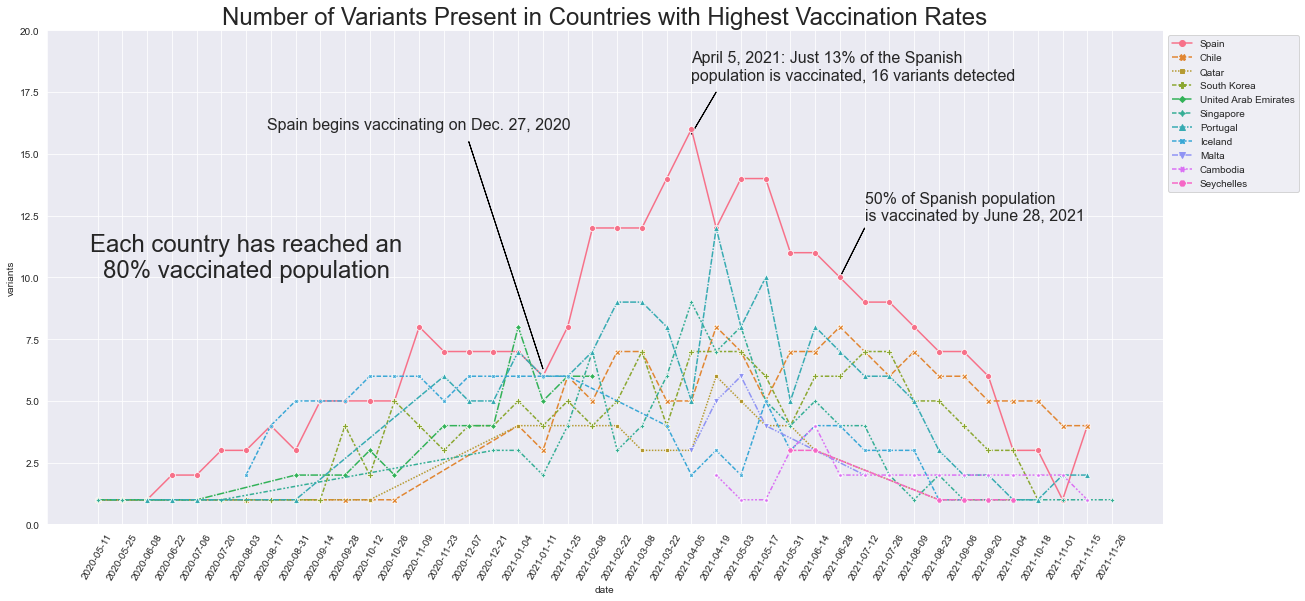

In [54]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# How have the numbers of variants increased or decreased over time? 
most_vaccinated =  max_vax.loc[max_vax['pct_pop_vaccinated'] > .8, 'location']
least_vaccinated = max_vax.loc[max_vax['pct_pop_vaccinated'] < .2, 'location']

most_vaxxed_variants_for_plotting = variants_cleaned.loc[variants_cleaned['location'].isin(most_vaccinated)].sort_values(['date'])
least_vaxxed_variants_for_plotting = variants_cleaned.loc[variants_cleaned['location'].isin(least_vaccinated)].sort_values(['date'])


plt.figure(figsize=(20, 20))

# Plotting the most vaccinated of all the countries
plt.subplot(2, 1, 1)
sns.lineplot(x='date', y='variants', hue='location', style='location', data=most_vaxxed_variants_for_plotting, markers=True)
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.title("Number of Variants Present in Countries with Highest Vaccination Rates", fontsize=24)
plt.xticks(rotation=60)
plt.ylim(0, 20)
plt.text('2020-11-09', 16, 'Spain begins vaccinating on Dec. 27, 2020', fontsize=16, horizontalalignment="center")
plt.arrow('2020-12-07', 15.5, 3, -9.2, color="black")
plt.text('2021-07-12', 12.3, '50% of Spanish population\nis vaccinated by June 28, 2021', fontsize=16, horizontalalignment="left")
plt.arrow('2021-07-12', 12, -1, -2, color="black")
plt.text('2021-04-05', 18, "April 5, 2021: Just 13% of the Spanish\npopulation is vaccinated, 16 variants detected", fontsize=16, horizontalalignment="left")
plt.arrow('2021-04-19', 17.5, -1, -1.7, color="black")
plt.text('2020-08-03',10, 'Each country has reached an\n80% vaccinated population', fontsize=24, horizontalalignment="center", )
plt.ylim(0, 20);


# # Plotting the least vaccinated of all the countries
# plt.subplot(2, 1, 2)
# sns.lineplot(x='date', y='variants', hue='location', style='location', data=least_vaxxed_variants_for_plotting)
# plt.legend(bbox_to_anchor=(1,1), loc="upper left");
# plt.title("Number of Variants Present in Countries with Lowest Vaccination Rates\nEach country has less than a 20% vaccinated population", fontsize=24)
# plt.xticks(rotation=60);
# # plt.text('2020-08-03', 10, 'Each country has less than a\n20% vaccinated population', fontsize=24, horizontalalignment="center", )
# plt.text('2021-02-22', 7, "Ghana reaches a maximum of\n8 variants on April 19, 2021", fontsize=16, horizontalalignment="right")
# plt.arrow('2021-02-22', 7.2, 3.8, .7, color="black")
# plt.ylim(0, 20);


###################################
# Outside Resource for Spain Facts: [0] - https://en.wikipedia.org/wiki/COVID-19_vaccination_in_Spain
###################################

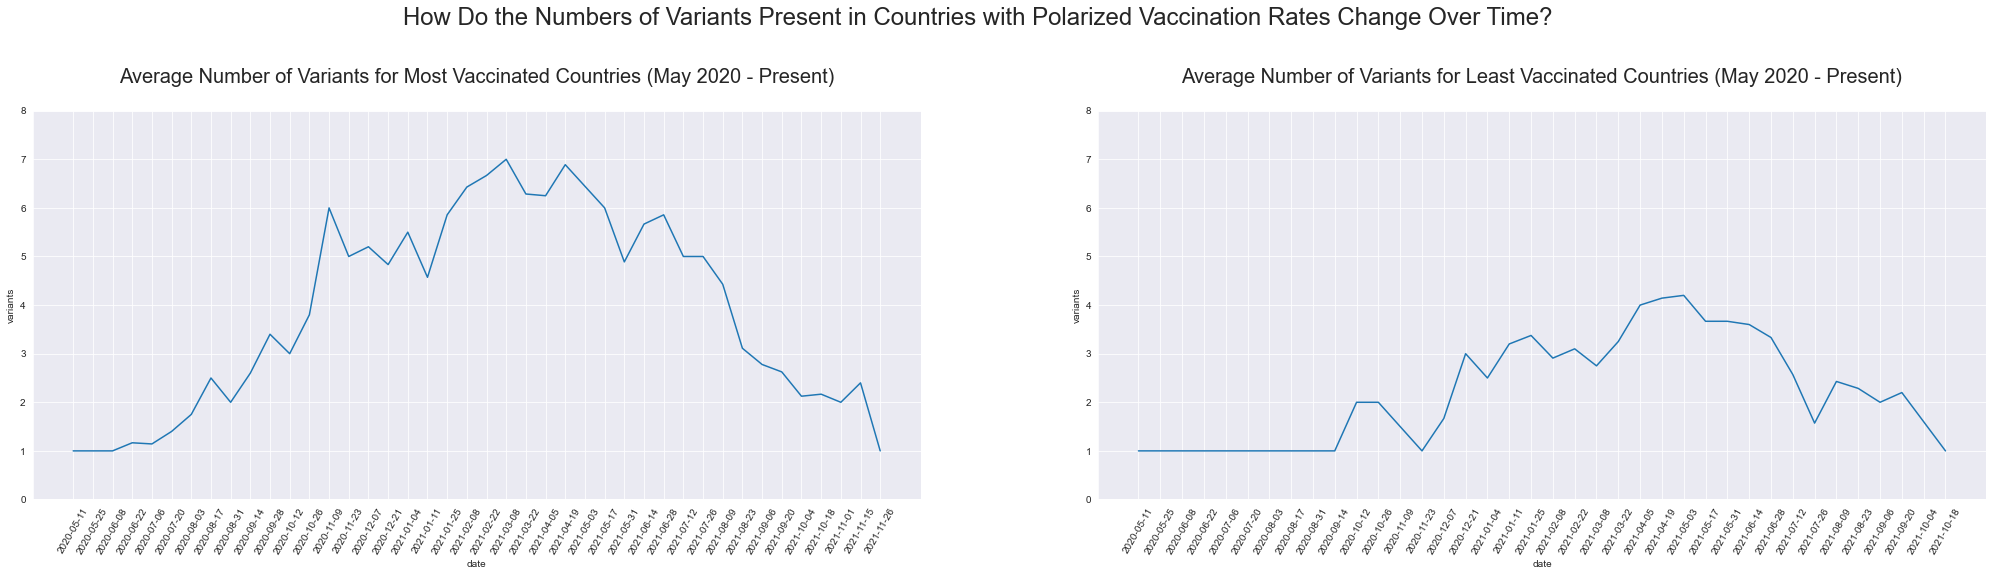

In [22]:
average_variants_highest_vaxxed_countries = most_vaxxed_variants_for_plotting.groupby(['date']).agg({'variants': np.mean})
average_variants_lowest_vaxxed_countries = least_vaxxed_variants_for_plotting.groupby(['date']).agg({'variants': np.mean})
plt.figure(figsize=(35, 8))
plt.suptitle("How Do the Numbers of Variants Present in Countries with Polarized Vaccination Rates Change Over Time?\n", fontsize=24)

plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='variants', data=average_variants_highest_vaxxed_countries, markers=True)
plt.title("Average Number of Variants for Most Vaccinated Countries (May 2020 - Present)\n", fontsize=20)
plt.subplots_adjust(top=.8) # Reduce plot to make room 
plt.xticks(rotation=60);
plt.ylim(0, 8)


plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='variants', data=average_variants_lowest_vaxxed_countries, markers=True)
plt.subplots_adjust(top=.8) # Reduce plot to make room 
plt.title("Average Number of Variants for Least Vaccinated Countries (May 2020 - Present)\n", fontsize=20)
plt.xticks(rotation=60)
plt.ylim(0, 8);

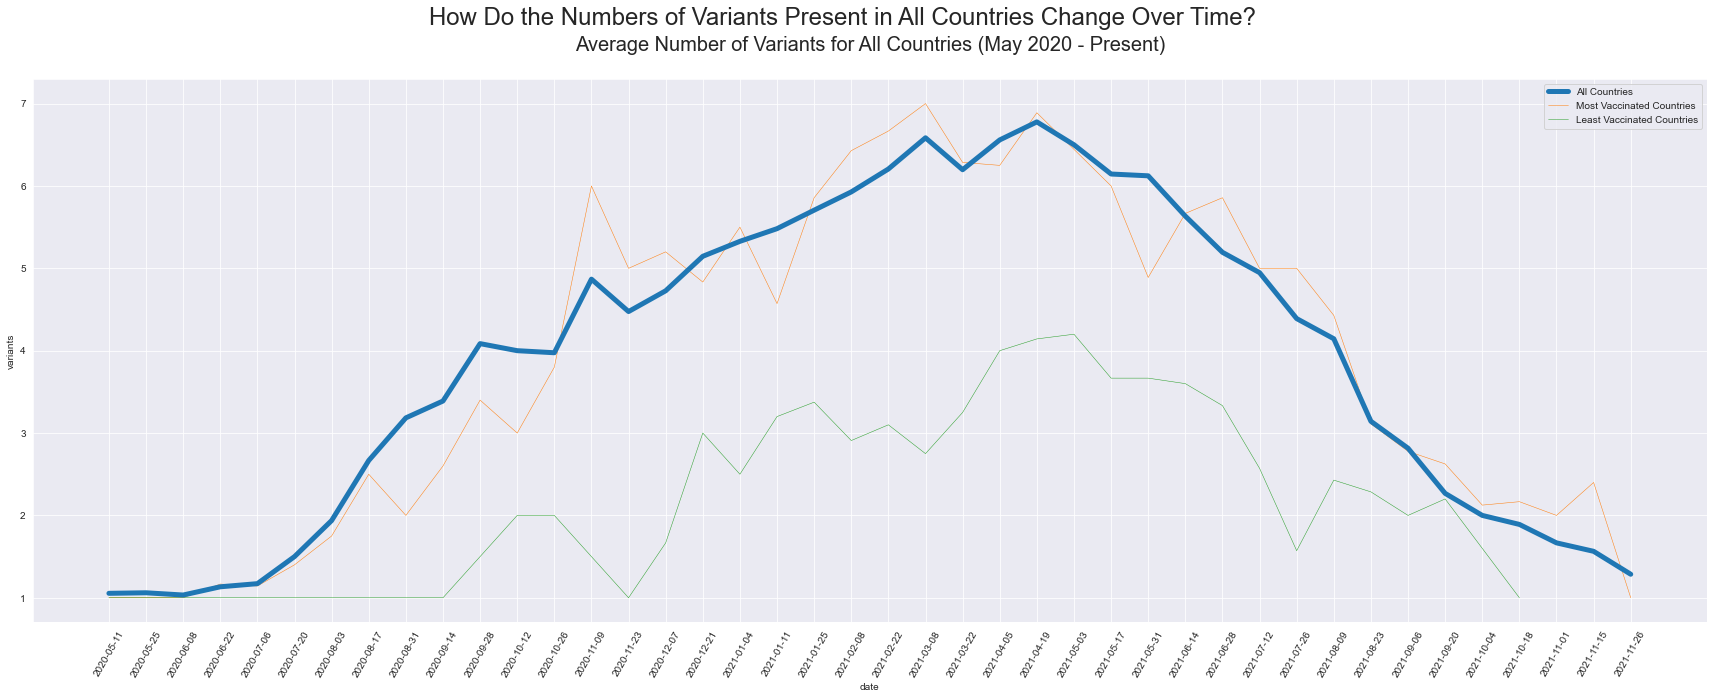

In [23]:
all_variants_over_time = variants_cleaned.groupby(['date'], as_index=False).agg({'variants': np.mean})
all_variants_over_time['timestamp'] = pd.to_datetime(all_variants_over_time['date'])

us_vaccinations = vaccinations_and_populations.loc[vaccinations_and_populations['location']=='United States'].sort_values('date')
# us_vaccinations.loc[us_vaccinations['pct_pop_vaccinated'] >= .5]
us_variants = variants_cleaned.loc[variants_cleaned['location'] == 'United States']

plt.figure(figsize=(30, 10))
plt.suptitle("How Do the Numbers of Variants Present in All Countries Change Over Time?\n", fontsize=24)
sns.lineplot(x='date', y='variants', data=all_variants_over_time, markers=True, lw=5, label="All Countries")
sns.lineplot(x='date', y='variants', data=average_variants_highest_vaxxed_countries, markers=True, zorder=1, lw=.5, label="Most Vaccinated Countries")
sns.lineplot(x='date', y='variants', data=average_variants_lowest_vaxxed_countries, markers=True, zorder=1, lw=.5, label="Least Vaccinated Countries")
plt.title("Average Number of Variants for All Countries (May 2020 - Present)\n", fontsize=20)
# plt.subplots_adjust(top=.8) # Reduce plot to make room 
plt.xticks(rotation=60);


<br><br> 

### Exploring the Data for the US, just because I'm curious...
The very first vaccinations began in the US around December 14, 2020. 
Approximately 50% of the US was vaccinated by about May 19, 2021. 

In [24]:
# The highest number of variants detected in the US to date is 16, 
# At what points in time were there 16 variants? 
us_variants.loc[us_variants['variants'] == 16]

,location,date,variants,year,month,seasons
2199,United States,2021-02-08,16,2021,02,Winter
2202,United States,2021-03-22,16,2021,03,Spring
2205,United States,2021-05-03,16,2021,05,Spring
2206,United States,2021-05-17,16,2021,05,Spring
2207,United States,2021-05-31,16,2021,05,Spring


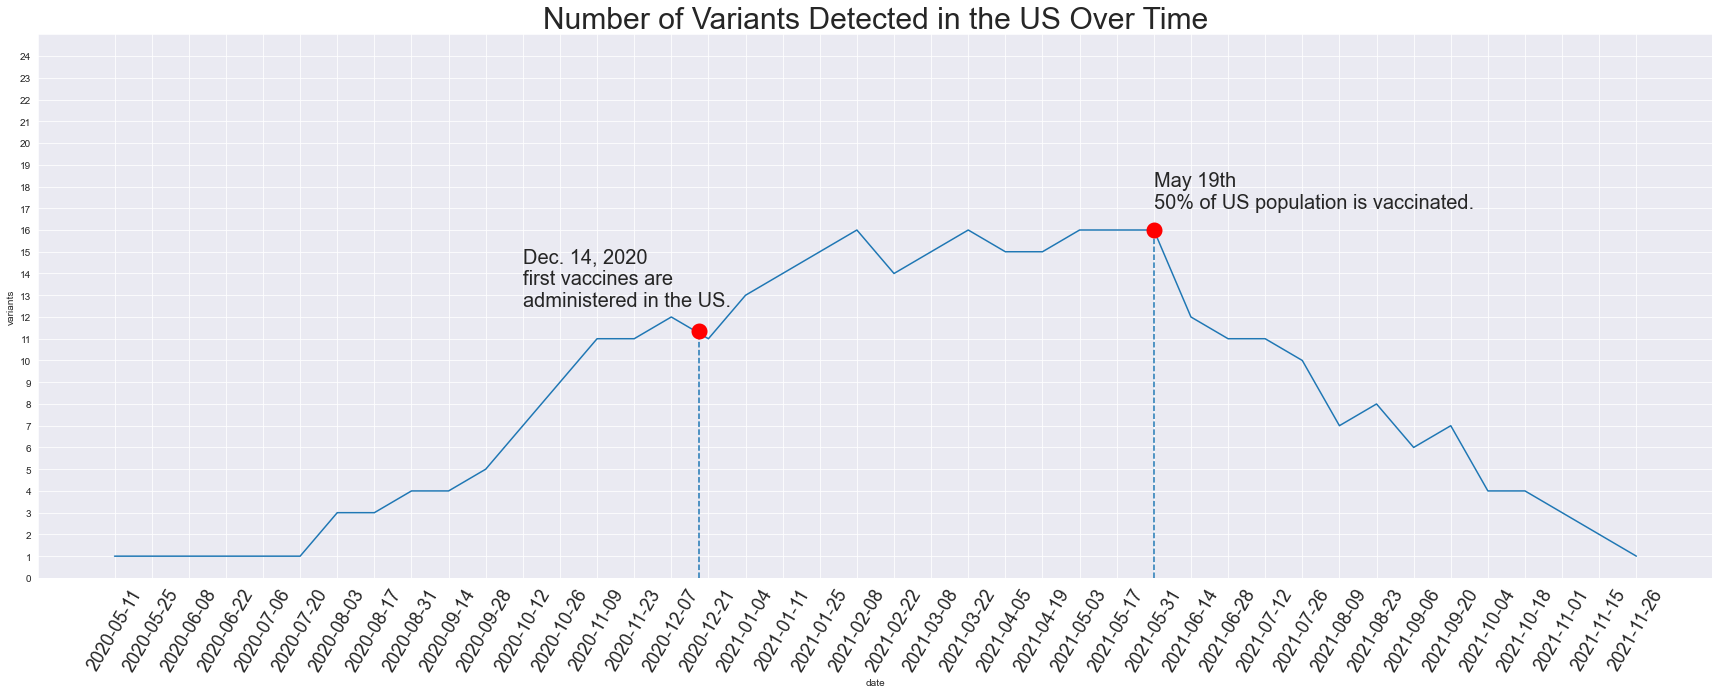

In [25]:
plt.figure(figsize=(30, 10))
sns.lineplot(x=us_variants['date'], y=us_variants['variants'], data=us_variants)
plt.xticks(rotation=60, fontsize=18);
plt.yticks(np.arange(0, 25))
plt.ylim(0, 25)
plt.scatter(15.75, 11.35, color='red', lw = 10, zorder=5)
plt.text(11, 12.5, "Dec. 14, 2020 \nfirst vaccines are\nadministered in the US.", fontsize=20)
plt.axvline(x=15.75, ymin=0, ymax=.45, linestyle='--')

plt.scatter(28, 16, color='red', lw=10, zorder=5)
plt.text(28, 17, "May 19th\n50% of US population is vaccinated.", fontsize = 20)
plt.axvline(x=28, ymin=0, ymax=.63, linestyle='--')
plt.title("Number of Variants Detected in the US Over Time", fontsize=30);

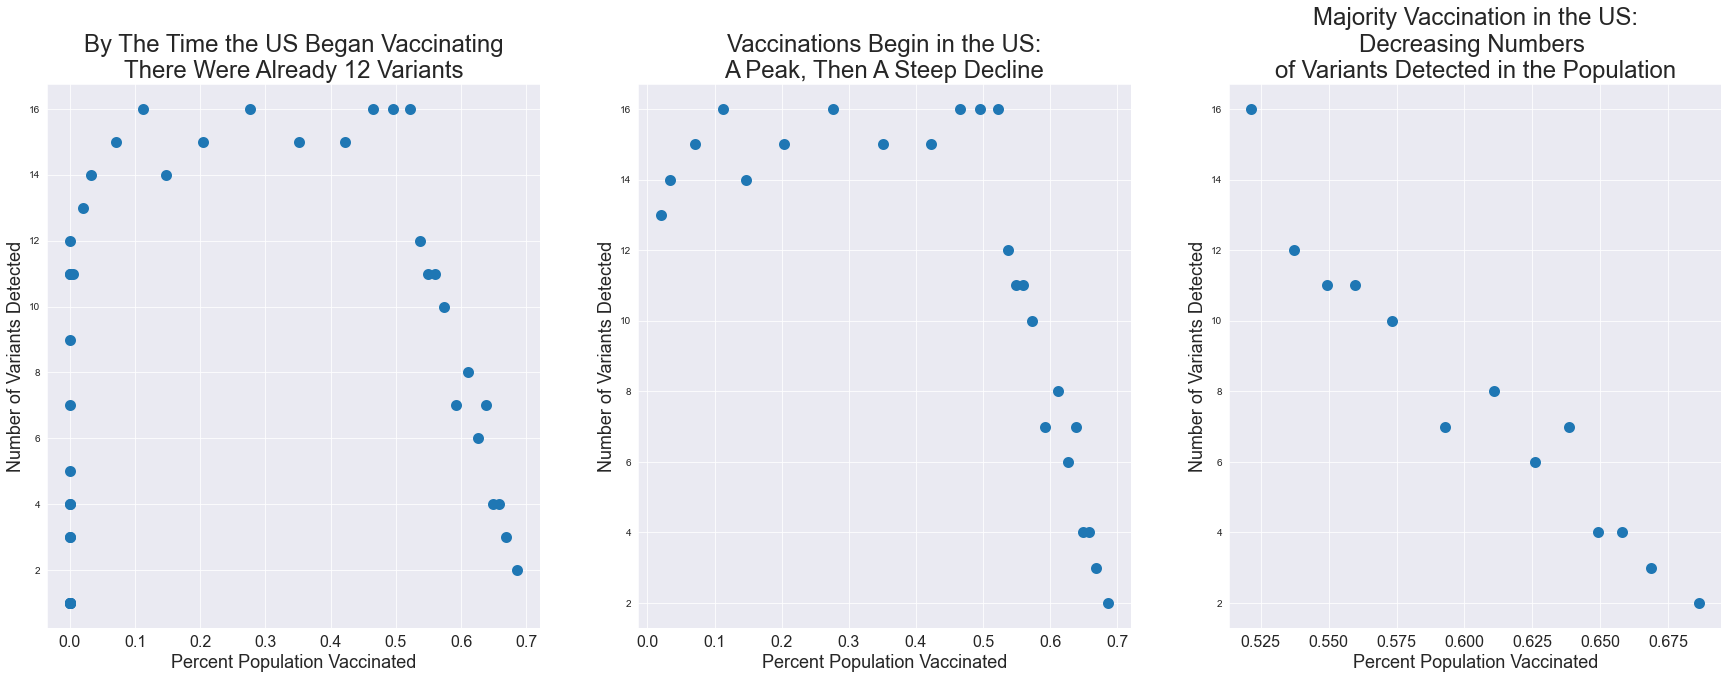

In [26]:
# So is there any kind of a relationship between the number of variants detected and the percentage of the population vaccinated? 
# I have every single day of vaccinations, but only some days of the variants testing results

all_us_variants_vaxxes = pd.merge(us_variants, us_vaccinations, how='left', left_on=['location', 'date'], right_on=['location', 'date']).fillna(0).iloc[:-1, :]
all_us_variants_vaxxes 

incept_vaxxes = all_us_variants_vaxxes.loc[all_us_variants_vaxxes['pct_pop_vaccinated'] >= .01]
incept_vaxxes

majority_vaccinated = all_us_variants_vaxxes.loc[all_us_variants_vaxxes['pct_pop_vaccinated'] > .5]
majority_vaccinated

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.scatter(all_us_variants_vaxxes['pct_pop_vaccinated'], all_us_variants_vaxxes['variants'], lw=5)
plt.title("By The Time the US Began Vaccinating\nThere Were Already 12 Variants", fontsize=24)
plt.xlabel("Percent Population Vaccinated", fontsize=18) 
plt.xticks(fontsize=16)
plt.ylabel("Number of Variants Detected", fontsize=18) 

plt.subplot(1, 3, 2)
plt.scatter(incept_vaxxes['pct_pop_vaccinated'], incept_vaxxes['variants'], lw=5)
plt.title("Vaccinations Begin in the US:\nA Peak, Then A Steep Decline", fontsize=24);
plt.xlabel("Percent Population Vaccinated", fontsize=18) 
plt.xticks(fontsize=16)
plt.ylabel("Number of Variants Detected", fontsize=18) 

plt.subplot(1, 3, 3)
plt.scatter(majority_vaccinated['pct_pop_vaccinated'], majority_vaccinated['variants'], lw=5)
plt.title("Majority Vaccination in the US:\nDecreasing Numbers \nof Variants Detected in the Population", fontsize=24);
plt.xlabel("Percent Population Vaccinated", fontsize=18) 
plt.xticks(fontsize=16)
plt.ylabel("Number of Variants Detected", fontsize=18) ;

<br><br>
______

## Does an increasingly vaccinated population have any relationship to a reduction in the number of COVID variants present in a country?

**Hypothesis Testing**

To try and answer this question, I'd like to do a simple linear regression starting at the point in which any given country reaches a majority-vaccinated population. I suspect that there is going to be *some kind* of relationship between the percentage of the population that is vaccinated, and the number of variants present in any given country. 

According to a some experts, approximately 60 - 70% of the total population needs to be vaccinated in order for the "pandemic to be over"$^{[6]}$$^{[7]}$. But of course, there must be some middle ground at which the vaccinations should be found to have *some* effect on detectable viral counts in a population. Additionally, there are countries whose vaccination rates are so low that they could not reasonably be expected to have had a significant effect on reducing the transmissibility of Covid in the population. When looking at the highest percentage of the total population vaccinated for each country, I can see that there is an incredible amount of inequality in terms of access to vaccines. For example, to date, Yemen has an approximate 2% of it's population vaccinated, while Sweden has roughly 72% of its population vaccinated and the United Arab Emirates is about 98% vaccinated. Filtering these countries with less than a majority of their population vaccinated out seems not only reasonable, but also a natural step in the process of answering the main question. **Thus, I am going to work with only those countries in which a majority (more than 50%) of the population has been vaccinated as my floor for countries on which I will sample from in order to test out my hypothesis.**

To determine whether or not the relationship between the increasingly vaccinated population and the number of variants present in a country is *significant*, I'll perform a Student's T-hypothesis test on the correlation coefficient at a $\alpha = 0.05$ level of significance. 

Let $\rho$ be the unknown population correlation coefficient...

**$H_0$: $\rho = 0$** The population correlation coefficient is roughly zero. In other words, there is no significant linear relationship between the percentage of the population being vaccinated (from a baseline of 50%) in the population, and the number of variants detected through testing, in the population. 

**$H_a$: $\rho \neq 0$** The population correlation coefficient is non-zero. There is some kind of linear relationship between having a majority-vaccinated population and the number of variants detected in the population. 

<br>

**What's the math?**


A simple linear model with a slope and an intercept term will be of the form: $\large \hat{y} = \theta_{0} + \theta_{1}x_{i}$ or, if you want to work with more familiar terms, $\large \hat{y} = a + bx_{i}$

I'm going to take the "lazy human" approach and numerically determine the optimal parameters. I'll be relying on a Python package function, but here's how that function works analytically: 

If we choose the squared loss function (and hence, the Mean Squared Error, which reduces the sum of the squares of our residuals), then we have to do a little calculus to find the minimum value for the loss function.

$MSE(y,  \hat{y}) = \frac{1}{n}\sum_{i=1}^n (y_{i} - \hat{y}_i)^{2}$, then this becomes $\frac{1}{n}\sum_{i=1}^n (y_{i} - (a + bx_{i}))^{2}$

**Minimizing the MSE for a linear model:**
So how to minimize the MSE for a linear function? There are now **two** parameters we need to minimize. So we need a new function, $R(a, b)$ which takes an $a$ and a $b$ and outputs the mean of the squared errors. 

$R(a, b) = \frac{1}{n}\sum_{i=1}^n (y_{i} - (a + bx_{i}))^{2}$

**First**--remember: 
 - the formula for the covariance, $COV = r\theta_{x}\theta_{y} = \frac{1}{n}\sum_{i=1}^{n}(x_{i} - \overline{x})(y_{i} -\overline{y})$
 - the formula for the variance of the x-values is $VAR = \theta_{x}^2 = \frac{1}{n}\sum(x_{i} - \overline{x})^2$

Start by taking the deriviate of $R$ with respect to $a$, setting to zero, then solving for $a$: 

$\frac{\partial{R}}{\partial{a}} (\frac{1}{n}\sum_{i=1}^n (y_{i} - (a + bx_{i}))^{2}) =  -2 (\frac{1}{n} \sum_{i=1}^n (y_{i} - a - bx_{i}))$

$ 0 = \frac{-2}{n} \sum_{i=1}^{n} (y_{i} - a - bx_{i})$

$ 0 = \sum_{i=1}^{n}y_{i} - \sum_{i=1}^{n}a - b\sum_{i=1}^{n}x_{i}$       

$ 0 = - na + \sum_{i=1}^{n}y_{i} - b\sum_{i=1}^{n}x_{i}$ 

$na = \sum_{i=1}^{n}y_{i} - b\sum_{i=1}^{n}x_{i}$ 

$a = \frac{1}{n}\sum_{i=1}^{n}y_{i} - \frac{1}{n} b\sum_{i=1}^{n}x_{i}$ 

$ \therefore \hat{a} = \overline{y} - b\overline{x}$

Next, take the derivative of $R$ with respect to $b$, setting to zero, then solving for $b$: 

$\frac{\partial{R}}{\partial{b}} (\frac{1}{n}\sum_{i=1}^n (y_{i} - ((\overline{y} - b\overline{x}) + bx_{i}))^{2}) = \frac{\partial{R}}{\partial{b}} (\frac{1}{n}\sum_{i=1}^n (y_{i} - \overline{y} - b\overline{x} - bx_{i})^{2})  = \frac{\partial{R}}{\partial{b}} (\frac{1}{n}\sum_{i=1}^n (y_{i} - \overline{y} - b(x_{i} - \overline{x}))^{2}  = \frac{-2}{n} \sum_{i=1}^{n}(y_{i} - \overline{y} - b(x_{i} - \overline{x}))(x_{i} - \overline{x}) = \frac{-2}{n} \sum_{i=1}^{n}(y_{i} - \overline{y})(x_{i} - \overline{x}) - (b(x_{i} - \overline{x}))(x_{i} - \overline{x})$

$0 = \sum_{i = 1}^{n}(y_{i} - \overline{y})(x_{i} - \overline{x}) - b\sum_{i=1}^{n} (x_{i} - \overline{x})^2$

$0 = n(r\theta_{x}\theta_{y}) - bn(\theta_{x}^2)$

$bn(\theta_{x}^2) = n(r\theta_{x}\theta_{y})$

$b = r\frac{\theta_{y}}{\theta_{x}}$

While that was super fun and everything, we can also do this using the `scipy.minimize()` function. 

**Finding the area under the curve:**

The PDF of the $\chi^2$ Distribution: $\large PDF(x) = \frac{\Gamma(\frac{v + 1}{2})} {\sqrt{v\pi} \Gamma(\frac{v}{2})} ( 1 + \frac{x^2}{v})^{-\frac{v + 1}{2}}$

The CDF of the $\chi^2$ Distribution: we'll just refer to this one as $F_X(t) = P(X \leq t) $

The CDF is the function we need. This function was so long and complicated, I was afraid to even try typing it out in LaTex. But this is what we'll use to effectively finds the value of the integral to the left of our test statistic. Thankfully, rather than calculating our values directly (and probably making some horrible mistakes along the way) we can simply use `stats.t.cdf` to find the area under the curve to the left of our test statistic. And since the T-distribution is symmetric, we'll just double this value and get our total p-value. 

**Calculating the P-Value**: 
To evaluate the p-value (the area under the curve in both of the tails in the extreme direction of our test statistic), we will need to calculate the area under the curve in both extreme directions of the test statistic and sum their combined areas. In other words, 

p-value = $\int_{-\infty}^{-t}PDF(x)dx + \int_{t}^{\infty}PDF(x)dx $ where PDF is the probability density function of the T-distribution. 

Rather than making any attempt to integrate that awfulness, we have tools available to us. I'll be using `stats.t.cdf` to calculate the area under the curve. 

**Summary of Important values:** 
 - $\large \hat{a} = \overline{y} + b\overline{x}$ where $a$ is the y-intercept term
 - $\large \overline{b} = r\frac{\theta_{y}}{\theta_{x}}$, where $b$ is the slope of the line
 - $\large r = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2\sum_{i=1}^{n}(y_i-\bar{y})^2}}$, our correlation coefficient
 - $\large t = \frac{r\sqrt{n - 2}}{\sqrt{1 - r^{2}}}$ our test statistic for the linear regression
 - $\large \alpha = 0.05$, our level of significance

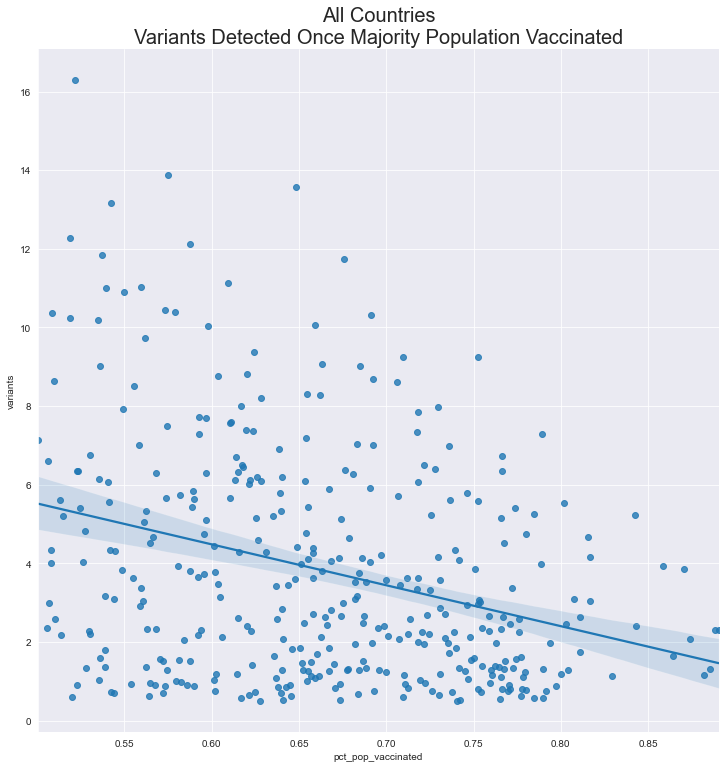

In [27]:
global_variants_and_vaccinations = pd.merge(variants_cleaned, vaccinations_and_populations, how='left', left_on=['location', 'date'], right_on=['location', 'date']).dropna(0)

global_majority_vaxxed = global_variants_and_vaccinations.loc[global_variants_and_vaccinations['pct_pop_vaccinated'] >= .5]
global_majority_vaxxed

# Pulling out a few interesting tidbits of information to use in plots
spain_start_majority = global_variants_and_vaccinations.loc[(global_variants_and_vaccinations['location']=='Spain') & (global_variants_and_vaccinations['pct_pop_vaccinated'] >.48)].reset_index().loc[0, 'date']
spain_start_majority

spanish_peak = global_variants_and_vaccinations.loc[(global_variants_and_vaccinations['location']=='Spain') & (global_variants_and_vaccinations['variants'] >15)]
spanish_peak

sns.lmplot(x='pct_pop_vaccinated', y='variants', data=global_majority_vaxxed, height=10, y_jitter=.5);
plt.title("All Countries\nVariants Detected Once Majority Population Vaccinated", fontsize=20);

I think that there is going to be a linear relationship between a majority vaccination as a percentage of the population and the number of variants. 

Again, I just want to note: The dataset `variants` is **not** the result of any random sampling. The variants included here are those that have been detected via genomic sequencing across the globe and deemed to be "variants of concern" or "variants of interest". Thus while performing my tests below, it's important to note that I am considering the *population* here to be the detectable traces of these variants themselves: the dataset *is* my population and I will be sampling randomly from that population. 

In [28]:
# I'll  be drawing from this dataset
global_majority_vaxxed

,location,date,variants,year_x,month_x,seasons_x,people_vaccinated,year_y,month_y,population,pct_pop_vaccinated,seasons_y
44,Argentina,2021-07-26,6,2021,07,Summer,23857637.00,2021,07,45605826.00,0.52,Summer
45,Argentina,2021-08-09,6,2021,08,Summer,26179454.00,2021,08,45605826.00,0.57,Summer
46,Argentina,2021-08-23,5,2021,08,Summer,27210308.00,2021,08,45605826.00,0.60,Summer
47,Argentina,2021-09-06,6,2021,09,Fall,28344998.00,2021,09,45605826.00,0.62,Fall
48,Argentina,2021-09-20,3,2021,09,Fall,29032591.00,2021,09,45605826.00,0.64,Fall
...,...,...,...,...,...,...,...,...,...,...,...,...
2215,United States,2021-09-20,7,2021,09,Fall,212586241.00,2021,09,332915073.00,0.64,Fall
2216,United States,2021-10-04,4,2021,10,Fall,216101885.00,2021,10,332915073.00,0.65,Fall
2217,United States,2021-10-18,4,2021,10,Fall,219088533.00,2021,10,332915073.00,0.66,Fall
2218,United States,2021-11-01,3,2021,11,Fall,222593391.00,2021,11,332915073.00,0.67,Fall



Drawing a random sample...

In [29]:
majority_sample = global_majority_vaxxed.sample(n=60, replace=True)
majority_sample

,location,date,variants,year_x,month_x,seasons_x,people_vaccinated,year_y,month_y,population,pct_pop_vaccinated,seasons_y
1735,Singapore,2021-08-09,1,2021,08,Summer,4373550.00,2021,08,5896686.00,0.74,Summer
363,Canada,2021-08-09,7,2021,08,Summer,27309482.00,2021,08,38067903.00,0.72,Summer
958,Ireland,2021-10-18,1,2021,10,Fall,3797475.00,2021,10,4982907.00,0.76,Fall
982,Israel,2021-09-20,2,2021,09,Fall,6081388.00,2021,09,8789774.00,0.69,Fall
743,Germany,2021-11-01,4,2021,11,Fall,57759484.00,2021,11,83900473.00,0.69,Fall
365,Canada,2021-09-06,4,2021,09,Fall,28156445.00,2021,09,38067903.00,0.74,Fall
2209,United States,2021-06-28,11,2021,06,Summer,182940062.00,2021,06,332915073.00,0.55,Summer
1818,Slovenia,2021-10-18,1,2021,10,Fall,1179408.00,2021,10,2078724.00,0.57,Fall
1379,New Zealand,2021-09-20,1,2021,09,Fall,3123588.00,2021,09,4860643.00,0.64,Fall
570,Ecuador,2021-08-23,8,2021,08,Summer,10670150.00,2021,08,17888475.00,0.60,Summer


In [30]:
from scipy.optimize import minimize

def linear_mse(arguments): 
    """The loss function for a linear model."""
    any_slope = arguments[0]
    any_intercept = arguments[1]
    x = majority_sample["pct_pop_vaccinated"]
    y = majority_sample["variants"]
    fitted_values = any_slope * x  + any_intercept
    return np.mean((y - fitted_values) ** 2)


initial_guess = (1, 2)
best_constants = minimize(linear_mse,  initial_guess)['x']
slope = best_constants[0]
intercept = best_constants[1]
r = np.corrcoef(x=majority_sample['pct_pop_vaccinated'], y=majority_sample['variants'])[1][0]

print(f"It appears as though the line of best-fit for our data is: \tf(x) = {slope:.3} * 'pct_pop_vaccinated' + {intercept:.3}")

print(f"The correlation coefficient is: {r:.3} and the coefficient of determination is {r ** 2:.3}.")

It appears as though the line of best-fit for our data is: 	f(x) = -15.4 * 'pct_pop_vaccinated' + 14.4
The correlation coefficient is: -0.413 and the coefficient of determination is 0.171.


In [31]:
slope

-15.412323655552939

In [32]:
# Calculating the value of the test statistic
test_stat = (r * (np.sqrt(len(majority_sample) - 2))) / (np.sqrt(1 - (r ** 2)))
test_stat

-3.4575852268744653

In [33]:
# Calculating the p-value for this two-tailed test first, adroit premier
p_value1 = stats.t.cdf(test_stat, df=len(majority_sample) - 2) * 2
p_value1

0.0010272408341367547

In [34]:
def conclude_test(alpha, p_value): 
    # Generating the confidence interval about the test statistic
    area_in_tails = alpha / 2
    
    # Using the inverse CDF (the integral from alpha/2 to infinity, and the integral from -infinity to alpha/2)
    left_bound = stats.t.ppf(area_in_tails, len(majority_sample) - 2)
    right_bound = stats.t.ppf(1 - area_in_tails, len(majority_sample) - 2)
    if p_value < alpha: 
        print("We reject the null.")
        print(f"Our test statistic {test_stat:.3} lies inside of the region of rejection: (-infinity, {left_bound:.3}], [{right_bound:.3}, infinity)")
        print("There appears to be a significant linear relationship between a population reaching majority vaccination, and a\n"
              "reduction in the number of variants detected via genomic testing on a global scale.")
    else: 
        print("We fail to reject the null:")
        print(f"Our test statistic {test_stat:.3} lies outside of the region of rejection: [{left_bound:.3}, {right_bound:.3}]")
        print("There is insufficient evidence to support the claim that there is a relationship between a population with a\n"
              " majority vaccinated or greater and a reduction in the number of variants detected via genomic testing on a global scale.")
    
    
conclude_test(0.05, p_value1)

We reject the null.
Our test statistic -3.46 lies inside of the region of rejection: (-infinity, -2.0], [2.0, infinity)
There appears to be a significant linear relationship between a population reaching majority vaccination, and a
reduction in the number of variants detected via genomic testing on a global scale.


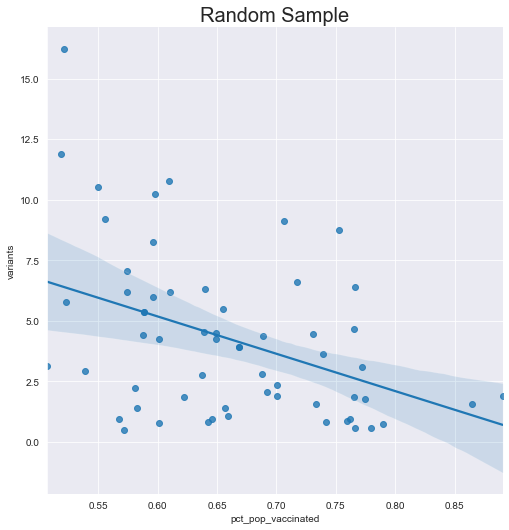

In [55]:
sns.lmplot(x='pct_pop_vaccinated', y='variants', data=majority_sample, height=7, y_jitter=.5);
plt.title("Random Sample", fontsize=20);

### Conclusion

Of course, I ran this test numerous times, just out of curiosity. Most of the time I got a result that ended up with me rejecting the null, and concluding that there could be a linear relation. Just looking at the data, I can see that there does appear to be a loose trend in the plotted points. But there were a couple of times in which I did not end up rejecting the null. 

Additionally, I have to re-iterate and re-address the nature of this data and how that affects the conclusions we could possibly draw.

First off, this is global data. There are bound to be inconsistencies, errors in reporting, and data-entry errors that we just can't account for here. Additionally, this is all based off of the data gathered from COVID testing. We know that testing data has some inherent bias that will come along with it: 
 - measurement bias: aggregated results can appear to have stronger relationships between variables. These same testing results can't be interpolated to apply to individuals. 
 - coverage bias: Assuming testing sites are only from large cities and locations where testing sites are economically viable, there are still chances that not all people who are sick with COVID have come in for testing. 
 - selection bias/confounding factors: People who go in for testing might be hypochondriacs. While people who don't go in for testing might be the 'ignorance is bliss' type--too afraid of a diagnosis to go in for testing. OR, the people who don't go in for testing might be too sick to get tested. 
 
Thus, any conclusions drawn from this data could be inaccurate due to confounding factors. 


**All that being said**, this served as an interesting and thought-provoking foray into the world of Covid variants. I *hope* that the CDC has access to more data than I have, and that the basis upon which they make their argument is thoroughly steeped in rigorous analyses. For my purposes, I performed a test, I had fun with some data, and found a common theme in the instances of a correlation between higher proportions of vaccinations and variants, but I wouldn't base any life decisions off of this. 

<br><br>
___________


### How about the distribution of Variants? Some initial exploration of the data...



Text(0.5, 1.0, 'Distribution of Variants\nMay 2020 - Present')

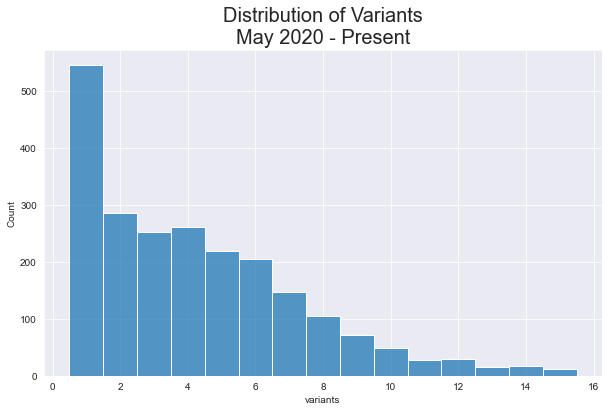

In [36]:
# So what does the distribution of variants look like when we look back over the last two years? 

# As was expected, the number of variants present in the population is NOT going to be normally distributed
plt.figure(figsize=(10, 6))

sns.histplot(variants_cleaned['variants'], bins=np.arange(0.5, 16.5, 1))
plt.title("Distribution of Variants\nMay 2020 - Present", fontsize=20)

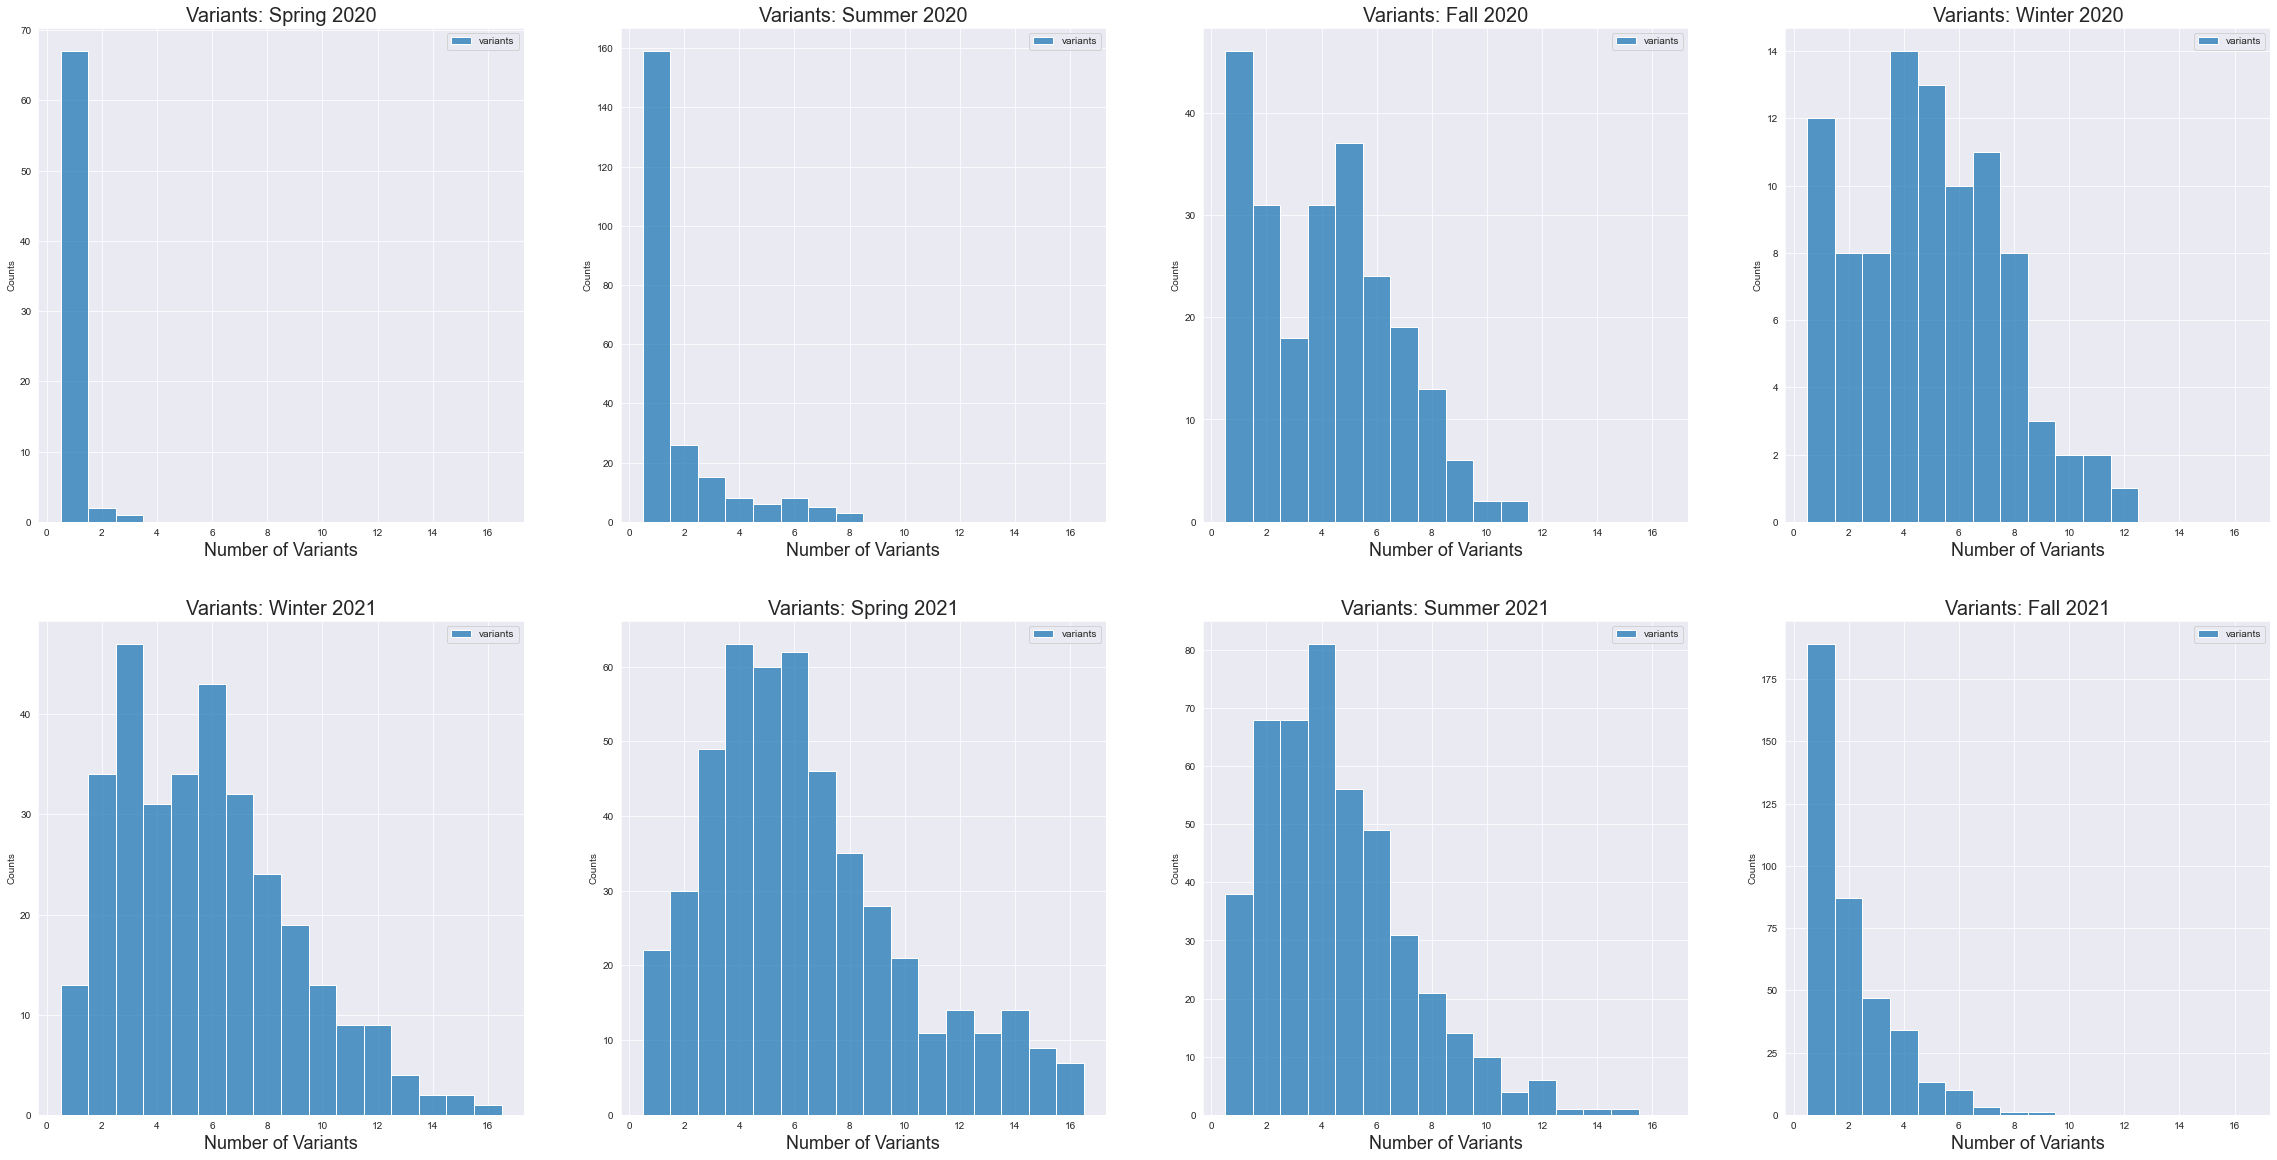

In [37]:
# What do the distributions look like on a seasonal level, by year? 
winter20_variants = variants_cleaned.loc[(variants_cleaned['seasons'] == 'Winter') & (variants_cleaned['year'] == '2020')]
winter21_variants = variants_cleaned.loc[(variants_cleaned['seasons'] == 'Winter') & (variants_cleaned['year'] == '2021')]

spring20_variants = variants_cleaned.loc[(variants_cleaned['seasons'] == 'Spring') & (variants_cleaned['year'] == '2020')]
spring21_variants = variants_cleaned.loc[(variants_cleaned['seasons'] == 'Spring') & (variants_cleaned['year'] == '2021')]

summer20_variants = variants_cleaned.loc[(variants_cleaned['seasons'] == 'Summer') & (variants_cleaned['year'] == '2020')]
summer21_variants = variants_cleaned.loc[(variants_cleaned['seasons'] == 'Summer') & (variants_cleaned['year'] == '2021')]

fall20_variants = variants_cleaned.loc[(variants_cleaned['seasons'] == 'Fall') & (variants_cleaned['year'] == '2020')]
fall21_variants = variants_cleaned.loc[(variants_cleaned['seasons'] == 'Fall') & (variants_cleaned['year'] == '2021')]


plt.figure(figsize=(40, 20))

plt.subplot(2, 4, 4)
sns.histplot(winter20_variants, bins=np.arange(0.5, 17.5, 1))
plt.title("Variants: Winter 2020", fontsize=20)
plt.xlabel("Number of Variants", fontsize=18)
plt.ylabel("Counts")

plt.subplot(2, 4, 1)
sns.histplot(spring20_variants, bins=np.arange(0.5, 17.5, 1))
plt.title("Variants: Spring 2020", fontsize=20)
plt.xlabel("Number of Variants", fontsize=18)
plt.ylabel("Counts")

plt.subplot(2, 4, 2)
sns.histplot(summer20_variants, bins=np.arange(0.5, 17.5, 1))
plt.title("Variants: Summer 2020", fontsize=20)
plt.xlabel("Number of Variants", fontsize=18)
plt.ylabel("Counts")

plt.subplot(2, 4, 3)
sns.histplot(fall20_variants, bins=np.arange(0.5, 17.5, 1))
plt.title("Variants: Fall 2020", fontsize=20)
plt.xlabel("Number of Variants", fontsize=18)
plt.ylabel("Counts")

plt.subplot(2, 4, 5)
sns.histplot(winter21_variants, bins=np.arange(0.5, 17.5, 1))
plt.title("Variants: Winter 2021", fontsize=20)
plt.xlabel("Number of Variants", fontsize=18)
plt.ylabel("Counts")

plt.subplot(2, 4, 6)
sns.histplot(spring21_variants, bins=np.arange(0.5, 17.5, 1))
plt.title("Variants: Spring 2021", fontsize=20)
plt.xlabel("Number of Variants", fontsize=18)
plt.ylabel("Counts")

plt.subplot(2, 4, 7)
sns.histplot(summer21_variants, bins=np.arange(0.5, 17.5, 1))
plt.title("Variants: Summer 2021", fontsize=20)
plt.xlabel("Number of Variants", fontsize=18)
plt.ylabel("Counts")

plt.subplot(2, 4, 8)
sns.histplot(fall21_variants, bins=np.arange(0.5, 17.5, 1))
plt.title("Variants: Fall 2021", fontsize=20)
plt.xlabel("Number of Variants", fontsize=18)
plt.ylabel("Counts");

<br><br>
_______

# Preparing for a $\chi^2$ Goodness-Of-Fit Test

By looking at the histograms of the variant data that there's no way it can be normally distributed. So what kind of a distribution is it? I can tell from looking at some of the histograms below that the data looks almost like an Exponential distribution or a Poisson Distribution. Which I could see making sense since most examples of exponential distributions are concerned with the amount of time until some specific event occurs. For this dataset to be considered in terms of an exponential distribution, we'd be concerned with the amount of time until a new variant is detected. So I want to perform a goodness-of-fit test for an exponential distribution to confirm or deny my hunch. 

Unfortunately, since I don't *know* what the population decay parameter to use for the expected values might be, I have to estimate it using some calculus and the maximum likelihood estimate. 

The likelihood function for this distribution is $L(\lambda: x_i, ..., x_j) = \lambda^ne^{(-\lambda\sum_{j=1}^{n}x_j})$. With the help of a little background knowledge of calculus and a lotta bit of Google, I know that the maximum likelihood can be determined as $\hat{\lambda} = \frac{n}{\sum_{j=1}^{n}x_j}$

$H_0$: The number of expected variants increases according to an exponential distribution with a decay parameter calculated from the maximum likelihood: In other words, the data fit an exponential distribution.

$H_a$: The data do not fit an exponential distribution. 

I'll test this at the $\alpha = 0.05$ level of confidence.

Resources:
 - https://www.statlect.com/fundamentals-of-statistics/exponential-distribution-maximum-likelihoodhttps://www.statlect.com/fundamentals-of-statistics/exponential-distribution-maximum-likelihood
 - https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading10b.pdfhttps://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading10b.pdf

### What's the math? 

$\large \chi^2_k$ where $k$ is the degrees of freedom.

The PDF of the $\chi^2$ Distribution: $\large PDF(x) = \frac{1}{2^{\frac{k}{2}} \Gamma(\frac{k}{2})} x^{\frac{k}{2 - 1}}e^{\frac{-x}{2}}$

The CDF of the $\chi^2$ Distribution: $\large \frac{1}{\Gamma(\frac{k}{2})}\gamma(\frac{k}{2}\frac{x}{2})$

test statistic: $ t = \sum\frac{(Observed - Expected)^2}{Expected}$ (for $n$ terms)

degrees of freedom: $df = ($ *number of categories* $ - 1)$ There are 16 total possible variants accounted for in our dataset. Therefore $df = 16 - 1 = 15$
 
I'll be discretizing my data and using the p-value approach again. This will of course be a right-tailed test, so to evaluate the area under the curve to the right of the test statistic, I'll need to take the integral of the probability density function from the test statistic to positive infinity. Like this: 

$p$-value $= \int_{t}^{\infty} PDF(x)dx $

But since that's kind of an awful function to integrate, we'll just rely on technology to help calculate the p-value. I'll use `1 - stats.chi2.cdf(t, df)` to calculate the p-value for this right-tailed test.

In [38]:
variants_cleaned

,location,date,variants,year,month,seasons
0,Angola,2020-12-21,3,2020,12,Winter
1,Angola,2021-01-25,6,2021,01,Winter
2,Angola,2021-02-08,4,2021,02,Winter
3,Angola,2021-02-22,5,2021,02,Winter
4,Angola,2021-03-08,4,2021,03,Spring
...,...,...,...,...,...,...
2249,Zimbabwe,2021-01-11,2,2021,01,Winter
2250,Zimbabwe,2021-01-25,2,2021,01,Winter
2251,Zimbabwe,2021-02-08,1,2021,02,Winter
2252,Zimbabwe,2021-07-12,1,2021,07,Summer


In [39]:
# Trying to find the maximum likelihood estimate for lambda, given my dataset
xs = variants_cleaned['variants'].sort_values()
xs

mle = len(xs) / np.sum(xs)
mle

0.23318849575832817

mean: 4.29, median: 4.0


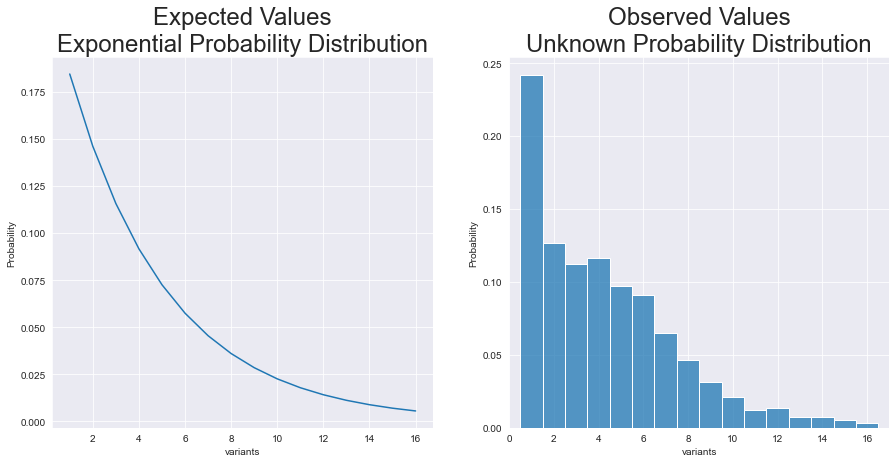

In [40]:
# Sweet, so the mle computed above should give me the single parameter needed for the formula for calculating the exponential PDF
def exp_pdf(x, lam_param): 
    return lam_param * (math.e ** -(lam_param * x))


# Manually handling the zeros
probs = exp_pdf(xs, mle)


mean_variants = np.mean(variants_cleaned['variants'])
median_variants = np.median(variants_cleaned['variants'])


# Mean and median are actually close
print(f"mean: {mean_variants:.3}, median: {median_variants}")

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(xs, probs)
plt.title("Expected Values\nExponential Probability Distribution", fontsize=24)
plt.xlabel('variants')
plt.ylabel('Probability');

plt.subplot(2, 2, 2)
plt.title("Observed Values\nUnknown Probability Distribution", fontsize=24)
sns.histplot(variants_cleaned['variants'], stat='probability', bins=np.arange(-0.5, 17.5, 1))
plt.xlim(0, 17);


In [41]:
# There are 2254 observations recorded. 
len(variants_cleaned)

2254

In [42]:
# Binning the observed data into probability bins
# There are 16 variants, so it makes sense to just bin by counts of 8 or 16...
binned_variants = variants_cleaned.copy()
interval_range = pd.interval_range(start=0, end=16)
binned_variants['bins'] = pd.cut(binned_variants['variants'], bins=interval_range, labels=[1,2,3])
obs_probs = binned_variants['bins'].value_counts() 
obs_probs

(0, 1]      546
(1, 2]      286
(3, 4]      262
(2, 3]      253
(4, 5]      219
(5, 6]      206
(6, 7]      147
(7, 8]      105
(8, 9]       71
(9, 10]      48
(11, 12]     30
(10, 11]     28
(13, 14]     17
(12, 13]     16
(14, 15]     12
(15, 16]      8
Name: bins, dtype: int64

In [43]:
# Getting the expected probabilities for each possible number of variants and storing into an array of len(16)
exp_data = probs.unique()
exp_data


array([0.18468628, 0.14627233, 0.11584831, 0.09175235, 0.07266826,
       0.05755357, 0.04558267, 0.03610167, 0.02859268, 0.02264552,
       0.01793535, 0.01420487, 0.01125032, 0.0089103 , 0.007057  ,
       0.00558917])

In [44]:
assert len(exp_data) == len(obs_probs)

In [45]:
# Making a little dataframe of my probabilities
goodfit_test_df = pd.DataFrame.from_dict({"observed": obs_probs, "expected": exp_data * len(variants_cleaned)})
goodfit_test_df['diffs^2/exp'] = ((goodfit_test_df['expected'] - goodfit_test_df['observed']) ** 2) / goodfit_test_df['expected']
goodfit_test_df

,observed,expected,diffs^2/exp
"(0, 1]",546,416.28,40.42
"(1, 2]",286,329.70,5.79
"(3, 4]",262,261.12,0.00
"(2, 3]",253,206.81,10.32
"(4, 5]",219,163.79,18.61
"(5, 6]",206,129.73,44.85
"(6, 7]",147,102.74,19.06
"(7, 8]",105,81.37,6.86
"(8, 9]",71,64.45,0.67
"(9, 10]",48,51.04,0.18


In [46]:
# We can already see that this is not going to be a good fit for the data. This test stat will lie
# FAR beyond any critical value we would ever consider. 
goodfit_test_stat = sum(goodfit_test_df['diffs^2/exp'])
goodfit_test_stat

156.17252734265261

In [47]:
ddof = len(goodfit_test_df) - 1
ddof

15

In [48]:
# Right-tailed test
p_value = 1 - stats.chi2.cdf(goodfit_test_stat, df= ddof, loc=0, scale=1)
p_value

0.0

In [49]:
critical_value = stats.chi2.ppf(0.05, df=15)
critical_value

7.2609439276700325

#### Conclusions: 

Unsurprisingly, we were able to determine that there is **significant evidence to support the claim that the data do not fit an exponential distribution with our estimated decay parameter.** To my untrained eyes, the distribution of the number of variants present does look as though it could be exponential, and perhaps there is some other distribution similar to an exponential distribution (likely much more complex) to which this data could be fitted. But for the purposes of this test, we can safely conclude that we have not found a good fit for the data. 

<br><br>

___________

# Concluding Remarks: 

I had a lot of fun working on this final project, although there were several points in which I almost regretted choosing real-world data. It's very messy. I thought about emailing several times after committing to that initial rough draft to ask whether or not I could change datsets. But I think this was an illuminating experience, if simply for the fact that I got the opportunity to experience what it's like to filter, organize, combine and completely disassemble real data. I imagine it will be a rare day indeed that I get handed pristine datasets from perfectly randomized controlled trials, or perfectly sampled random data. Obviously I have loads to learn, and I need more experience. There will be things that I did wrong, and things I could do better. Any and all feedback is much appreciated! 

Many thx!

<br><br>
__________
## Resources: 

 - $[\dagger]$ https://nypost.com/2021/11/26/new-covid-variant-detected-in-south-africa-prompts-uk-travel-ban/
 - $[\star]$ https://www.upi.com/Top_News/US/2021/11/27/state-department-advises-against-travel-south-africa-omicron/3621638049970/
 - $[\ddagger]$ Emma B. Hodcroft. 2021. "CoVariants: SARS-CoV-2 Mutations and Variants of Interest." https://covariants.org/
 - $[0]$ https://en.wikipedia.org/wiki/COVID-19_vaccination_in_Spain
 - $[\diamond]$ https://www.cdc.gov/coronavirus/2019-ncov/variants/omicron-variant.html